<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Notebooks/BAF_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [7]:
#!git clone https://github.com/MDankloff/Cluster-Bias-Disco.git
#!cd Cluster-Bias-Disco/
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install dask[dataframe]

In [9]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.utils import resample

# Load data and Best LightGBM Models

Sets of features (data columns)

In [36]:
#MASTER DATASET

META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['payment_type', 'days_since_request', 'bank_branch_count_8w', 'credit_risk_score', 'source', 'device_os','month', 'session_length_in_minutes',
       'velocity_6h', 'velocity_24h', 'velocity_4w', 'email_is_free', 'proposed_credit_limit', 'keep_alive_session'] #, 'intended_balcon_amount']
SEN = ['customer_age', 'income', 'employment_status'] #protected attributes in BAF paper
PROX = ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'zip_count_4w', 'date_of_birth_distinct_emails_4w',
        'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request',
        'device_distinct_emails']

################################## SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['payment_type_scaled', 'days_since_request_scaled', 'bank_branch_count_8w_scaled', 'credit_risk_score_scaled',
              'source_scaled', 'device_os_scaled','month_scaled', 'session_length_in_minutes_scaled',
              'velocity_6h_scaled', 'velocity_24h_scaled', 'velocity_4w_scaled', 'email_is_free_scaled', 'proposed_credit_limit_scaled', 'keep_alive_session_scaled'] #, 'intended_balcon_amount_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled', 'employment_status_scaled']
PROX_scaled = [['name_email_similarity_scaled', 'prev_address_months_count_scaled', 'current_address_months_count_scaled', 'zip_count_4w_scaled',
                'date_of_birth_distinct_emails_4w_scaled','housing_status_scaled', 'phone_home_valid_scaled', 'phone_mobile_valid_scaled',
                'bank_months_count_scaled', 'has_other_cards_scaled', 'foreign_request_scaled', 'device_distinct_emails_scaled']]

'''Removed features:
device_fraud_count
device_fraud_count_scaled
intended_balcon_amount
intended_balcon_amount_scaled
'''

'Removed features:\ndevice_fraud_count\ndevice_fraud_count_scaled\nintended_balcon_amount\nintended_balcon_amount_scaled\n'

load data from parquet files

In [37]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


load best models from BAF_Reproduce notebook

In [38]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model per variant
modelb = models.get("model_Base_top_4")
modelv1 = models.get("model_Variant I_top_4")
modelv2 = models.get("model_Variant II_top_4")
modelv3 = models.get("model_Variant III_top_0")
modelv4 = models.get("model_Variant IV_top_6")
modelv5 = models.get("model_Variant V_top_0")

# Explore data

In [58]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

In [59]:
pd.set_option('display.max_columns', 50) # Increase the maximum number of columns displayed in Pandas to 50
pd.set_option('display.max_rows', 50)

In [60]:
dfs = [base, variant1, variant2, variant3, variant4, variant5]

dfb = base
old_dfb = base.copy()
df1 = variant1
old_df1 = df1.copy()
df2 = variant2
old_df2 = df2.copy()
df3 = variant3
old_df3 = df3.copy()
df4 = variant4
old_df4 = df4.copy()
df5 = variant5
old_df5 = df5.copy()
# Get the number of unique values in each column of the DataFrame
df1.nunique()

,0
fraud_bool,2
income,9
name_email_similarity,998824
prev_address_months_count,371
current_address_months_count,420
customer_age,9
days_since_request,989360
payment_type,5
zip_count_4w,6303
velocity_6h,998714


In [61]:
#remove features --> check for missing values first
features_to_remove = ['device_fraud_count', 'intended_balcon_amount']


for df_name, df in dataframes.items():
  for column in features_to_remove:
    if column in df.columns:
     df.drop(column, axis=1, inplace=True)


In [62]:
#variant1.iloc[500]
df1.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,0,0.9,0.990415,11.0,4.0,40,0.014640,AC,1853,6711.523027,4868.779488,4988.827961,0,19,CA,113,1,BC,0,1,NaN,0,200.0,0,INTERNET,6.150317,windows,0,1.0,0
1,0,0.4,0.781728,NaN,151.0,30,0.013269,AA,5447,8948.772349,5824.765506,6451.180606,16,14,CA,83,1,BB,0,1,5.0,0,1500.0,0,INTERNET,4.521952,windows,1,1.0,0
2,0,0.7,0.274290,NaN,92.0,20,0.010669,AA,2312,11727.292100,7679.867045,6731.304261,1351,15,CA,70,0,BC,1,1,28.0,0,200.0,0,INTERNET,8.361707,other,1,1.0,0
3,0,0.9,0.722684,NaN,55.0,20,0.021849,AA,2413,4126.145203,4458.366351,6356.833258,30,8,CA,222,1,BD,1,1,20.0,0,1500.0,0,INTERNET,7.339743,other,0,1.0,0
4,0,0.9,0.121661,NaN,51.0,20,0.021491,AB,1227,9730.276231,5544.081678,6721.196241,505,12,CA,126,1,BE,0,1,1.0,0,1500.0,0,INTERNET,4.338063,other,0,1.0,0


In [63]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.560867,0.290389,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.494652,0.288847,5.024707e-08,0.226846,0.492220,0.755838,1.000000
prev_address_months_count,295633.0,59.751405,62.534715,6.000000e+00,25.000000,34.000000,65.000000,399.000000
current_address_months_count,995558.0,83.962797,86.465722,0.000000e+00,19.000000,51.000000,124.000000,429.000000
customer_age,1000000.0,31.974200,10.897167,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.051720,5.462110,1.373749e-08,0.007151,0.015104,0.026185,76.635022
zip_count_4w,1000000.0,1574.468789,1003.700453,1.000000e+00,893.000000,1270.000000,1952.000000,6678.000000
velocity_6h,1000000.0,5661.914760,3010.869604,-1.741097e+02,3431.170414,5299.991908,7692.312342,16817.838935
velocity_24h,1000000.0,4767.082829,1481.613486,1.322325e+03,3587.024902,4745.547722,5753.146673,9539.356530


In [64]:
df1.describe(include=["object", "bool"]).transpose()

,count,unique,top,freq
payment_type,1000000,5,AB,364724
employment_status,1000000,7,CA,742492
housing_status,1000000,7,BC,380697
source,1000000,2,INTERNET,993214
device_os,1000000,5,other,352678


In [65]:
df1_frauds = pd.DataFrame(df1['fraud_bool'].value_counts())
print(df1_frauds)

             count
fraud_bool        
0           988971
1            11029


missing values

In [66]:
missing_vals = pd.DataFrame()
missing_features = ['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

#replace -1 values with NaN, calculate percentage of missing values

for feature in missing_features:
  df1.loc[df1[feature] < 0, feature] = np.nan
  missing_vals_col = df1.groupby('fraud_bool')[feature].apply(lambda x: round(x.isna().sum()/len(x)* 100, 2))
  missing_vals[feature] = missing_vals_col

print(missing_vals)

            prev_address_months_count  current_address_months_count  \
fraud_bool                                                            
0                               70.22                          0.45   
1                               90.24                          0.10   

            bank_months_count  session_length_in_minutes  \
fraud_bool                                                 
0                       25.35                       0.18   
1                       38.53                       0.12   

            device_distinct_emails_8w  
fraud_bool                             
0                                0.03  
1                                0.02  


In [67]:
(df['current_address_months_count']).value_counts()

,count
current_address_months_count,
6,13656
7,13651
8,13603
9,13267
5,13142
...,...
411,1
408,1
409,1


numeric features

In [68]:
numeric_features = [x for x in df1.columns if df1[x].nunique() >= 10]
print(numeric_features)

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes']


categorical features

In [69]:
categorical_features = [x for x in df1.columns if df1[x].dtypes == "O"]

print(categorical_features)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [70]:
#df1.nunique()

In [71]:
df1.describe(include=["object", "bool"]).transpose()


,count,unique,top,freq
payment_type,1000000,5,AB,364724
employment_status,1000000,7,CA,742492
housing_status,1000000,7,BC,380697
source,1000000,2,INTERNET,993214
device_os,1000000,5,other,352678


In [72]:
#device fraud count was binary but 0 counts for class 1 so this feature is removed
'''df1['device_fraud_count'].value_counts()
count_device = (df1['device_fraud_count'] ==1).sum()
print(count_device)'''

"df1['device_fraud_count'].value_counts()\ncount_device = (df1['device_fraud_count'] ==1).sum()\nprint(count_device)"

In [73]:
#df1['customer_age'].value_counts() #same as variant3

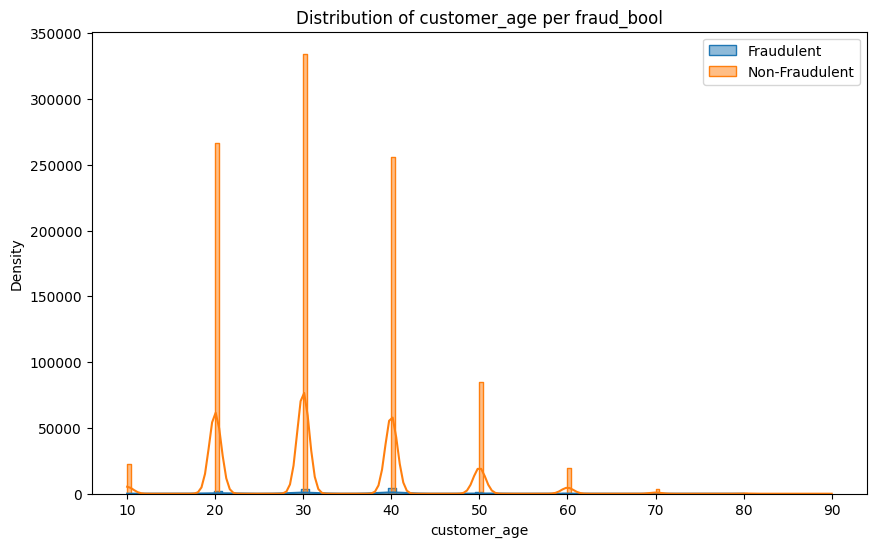

In [74]:
fraud_age = df1.loc[df1['fraud_bool'] == 1, 'customer_age']
nonfraud_age = df1.loc[df1['fraud_bool'] == 0]['customer_age']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_age, kde=True, label='Fraudulent', element='step')
sns.histplot(nonfraud_age, kde=True, label='Non-Fraudulent', element='step')


plt.title('Distribution of customer_age per fraud_bool')
plt.xlabel('customer_age')
plt.ylabel('Density')
plt.legend()
plt.show() #do this plot again after upsampling

In [75]:
df1['customer_age'].value_counts()
df1['income'].value_counts()
df1['employment_status'].value_counts()

,count
employment_status,
CA,742492
CB,137901
CF,43573
CD,26232
CC,25806
CE,23562
CG,434


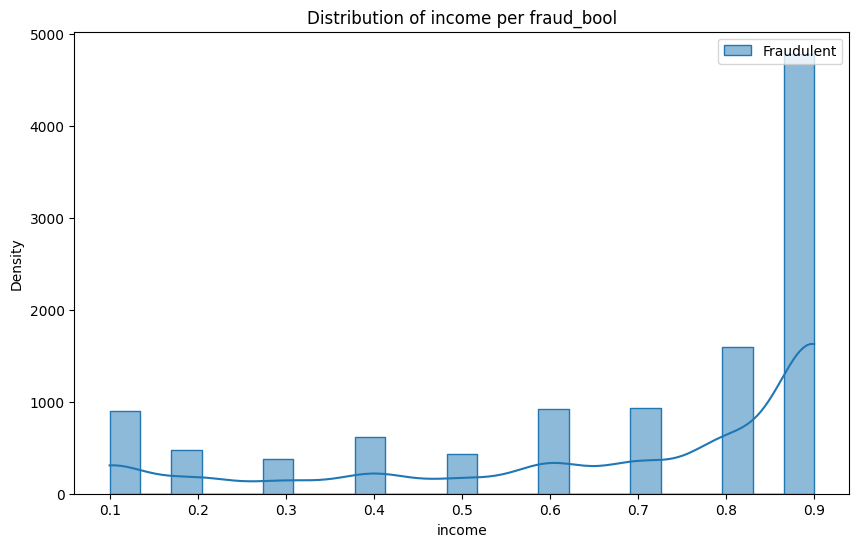

In [76]:
fraud_income = df1.loc[df1['fraud_bool'] == 1, 'income']
nonfraud_income = df1.loc[df1['fraud_bool'] == 0,'income']

plt.figure(figsize=(10, 6))
sns.histplot(fraud_income, kde=True, label='Fraudulent', element='step')
sns.histplot()

plt.title('Distribution of income per fraud_bool')
plt.xlabel('income')
plt.ylabel('Density')
plt.legend()
plt.show()

# Pre-process

Upsample to deal with imbalanced dataset

In [77]:
df1_frauds = pd.DataFrame(df1['fraud_bool'].value_counts())
print(df1_frauds)

             count
fraud_bool        
0           988971
1            11029


In [78]:
def upsample_minority_classes(dfs, target_column, minority_ratio=0.1, random_state=42):
    """
    Upsample the minority class proportional to the majority class

    Parameters:
    - dfs (list): List of pandas DataFrames to process.
    - target_column (str): The name of the column containing the target labels (e.g., 'fraud_bool').
    - minority_ratio (float): The desired ratio of minority samples to majority samples. Default is 0.1.
    - random_state (int): Random seed for reproducibility. Default is 42.

    Returns:
    - list: A list of DataFrames with the minority class upsampled.
    """
    upsampled_dfs = []

    for df in dfs:
        # Split into majority and minority classes
        df_majority = df[df[target_column] == 0]
        df_minority = df[df[target_column] == 1]

        # Calculate the number of samples for upsampling
        n_samples = int(minority_ratio * len(df_majority) / (1 - minority_ratio))
        #n_samples = len(df_majority) # choose for equal class sizes

        # Upsample minority class
        df_minority_upsampled = resample(
            df_minority,
            replace=True,
            n_samples=n_samples,
            random_state=random_state
        )

        # Combine majority and upsampled minority classes
        df_upsampled = pd.concat([df_majority, df_minority_upsampled])

        # Add the upsampled dataframe to the list
        upsampled_dfs.append(df_upsampled)

    return upsampled_dfs

In [79]:
dfb_up = upsample_minority_classes([dfb], target_column="fraud_bool", minority_ratio=0.1)[0]
df1_up = upsample_minority_classes([df1], target_column="fraud_bool", minority_ratio=0.1)[0]
df2_up = upsample_minority_classes([df2], target_column="fraud_bool", minority_ratio=0.1)[0]
df3_up = upsample_minority_classes([df3], target_column="fraud_bool", minority_ratio=0.1)[0]
df4_up = upsample_minority_classes([df4], target_column="fraud_bool", minority_ratio=0.1)[0]
df5_up = upsample_minority_classes([df5], target_column="fraud_bool", minority_ratio=0.1)[0]

In [80]:
print(df1_up.fraud_bool.value_counts())

fraud_bool
0    988971
1    109885
Name: count, dtype: int64


# Get the Errors

In [81]:
train_dfs = {key: df[df["month"] < 6].sample(frac=1, replace=False) for key, df in dataframes.items()}
test_dfs = {key: df[df["month"] >= 6].sample(frac=1, replace=False) for key, df in dataframes.items()}

In [90]:
def get_errors(model, label, test_dfs, upsampled_dfs):
    """
    Evaluate a trained model on test data and compute metrics and errors.

    Parameters:
    - model: Trained model (e.g., LightGBM, Random Forest, etc.).
    - label: The key to access specific test and upsampled data (e.g., 'Base', 'Variant I').
    - test_dfs (dict): Dictionary containing test DataFrames keyed by their labels.
    - upsampled_dfs (dict): Dictionary containing upsampled training DataFrames keyed by their labels.

    Returns:
    - metrics (dict): Dictionary of evaluation metrics (accuracy, precision, recall, f1, ROC AUC).
    - predictions (DataFrame): DataFrame with true labels, predicted labels, and error flags.
    """

    # Extract train and test data for the specified label
    X_test = test_dfs[label].drop(columns=["fraud_bool"])
    Y_test = test_dfs[label]["fraud_bool"]

    # Predict using the model
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]  # Probability for ROC AUC calculation (class 1)

    # Ensure predictions and true labels are integers
    Y_pred = Y_pred.astype(int)
    Y_test = Y_test.astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_prob)

    # Print evaluation metrics and confusion matrix
    print(f"Metrics for {label}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {label}')
    plt.show()

    # Create predictions DataFrame with error flags
    predictions = pd.DataFrame({
        'true_class': Y_test,
        'predicted_class': Y_pred,
        'errors': (Y_pred != Y_test).astype(int)
    }, index=X_test.index)

    # Merge predictions with the original test data
    test_dfs[label] = pd.concat([test_dfs[label], predictions], axis=1)

    # Return metrics and predictions
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }, predictions

Add the metrics and errors to all variants

In [92]:
# Example: Process and evaluate all data variants

# Create a dictionary to store upsampled DataFrames
upsampled_dfs = {
    'Base': dfb_up,
    'Variant I': df1_up,
    'Variant II': df2_up,
    'Variant III': df3_up,
    'Variant IV': df4_up,
    'Variant V': df5_up
}

# Evaluate each model and capture metrics/errors
results = {}
for label, model in zip(
    ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V'],
    [modelb, modelv1, modelv2, modelv3, modelv4, modelv5]
):
    metrics, errors = get_errors(model, label, test_dfs, upsampled_dfs)
    results[label] = {
        'metrics': metrics,
        'errors': errors
    }

# Example: View metrics for 'Variant I'
print("Metrics for Variant I:")
print(results['Variant I']['metrics'])

# Example: View the test DataFrame for 'Variant I' with errors added
print("Test DataFrame with Errors for Variant I:")
print(test_dfs['Variant I'].head())

AttributeError: 'NoneType' object has no attribute 'predict'

In [88]:
base_metrics, base_error = get_errors(modelb, 'Base', test_dfs, upsampled_dfs)
v1_metrics, v1_error = get_errors(modelv1, 'Variant I', test_dfs, upsampled_dfs)
v2_metrics, v2_error = get_errors(modelv2, 'Variant II', test_dfs, upsampled_dfs)
v3_metrics, v3_error = get_errors(modelv3, 'Variant III', test_dfs, upsampled_dfs)
v4_metrics, v4_error = get_errors(modelv4, 'Variant IV', test_dfs, upsampled_dfs)
v5_metrics, v5_error = get_errors(modelv5, 'Variant V', test_dfs, upsampled_dfs)


print(test_dfs(df1_up).head())  # Includes original columns + true_class, predicted_class, errors
#print(test_dfs['Variant I'].head())  # Includes the same for 'Variant I'''

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
df_error = get_errors(modelb, 'Base', test_dfs)

In [ ]:
# Rename updated datasets to new variables
Base_error = test_dfs['Base']
V1_error = test_dfs['Variant I']
V2_error = test_dfs['Variant II']
V3_error = test_dfs['Variant III']
V4_error = test_dfs['Variant IV']
V5_error = test_dfs['Variant V']

# Get the error labels

In [ ]:
def add_error_labels(df):
    df['TP'] = ((df['true_class'] == 1) & (df['predicted_class'] == 1)).astype(int)
    df['TN'] = ((df['true_class'] == 0) & (df['predicted_class'] == 0)).astype(int)
    df['FN'] = ((df['true_class'] == 1) & (df['predicted_class'] == 0)).astype(int)
    df['FP'] = ((df['true_class'] == 0) & (df['predicted_class'] == 1)).astype(int)
    return df

# Apply the function to each error dataset
Base_error = add_error_labels(Base_error)
V1_error = add_error_labels(V1_error)
V2_error = add_error_labels(V2_error)
V3_error = add_error_labels(V3_error)
V4_error = add_error_labels(V4_error)
V5_error = add_error_labels(V5_error)

In [ ]:
Base_error.head()
#Base_error.iloc[500]

In [ ]:
#Check if there are any FP/FN
#Base_error[Base_error['FN']==1]

# Add SHAP values on testset

In [ ]:
!pip install shap
import shap

 TreeExplainer is specifically optimized for tree-based models such as LightGBM, XGBoost, and CatBoost.

In [ ]:
X_train = (train_dfs[Base_error].drop(columns=["fraud_bool"]))


explainer = shap.TreeExplainer(modelb, X_train)